In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model
import warnings
from tensorflow.keras.layers import Dense, Flatten, Activation, Dropout, Embedding, Conv1D, Conv2D, MaxPooling2D, \
    MaxPooling1D, Concatenate, BatchNormalization, GaussianNoise
from tensorflow.keras.layers import LSTM, TimeDistributed, Permute, Reshape, Lambda, RepeatVector, Input, Multiply, \
    SimpleRNN, GRU, LeakyReLU
import site
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
import h5py as h5
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import errno
import os
from collections import defaultdict
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.summary import create_file_writer
from sklearn.model_selection import train_test_split


In [2]:
%pip install keras-tuner
%pip install keras_self_attention

     |████████████████████████████████| 71kB 5.6MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78938 sha256=c9d2ec5205ed2bf8705ee2d9e9edac53a6bfdaec3d2245d87a73c7f635d5b7f1
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=5f573338194909e13010da91881894c3c02ade9e01e5e3e0963b8b273ef21c96
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [4]:
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
import kerastuner as kt


In [5]:
pd.set_option('display.width', 400)
pd.set_option('display.max_columns', 40)


In [14]:
def coShuffled_vectors(X, Y):
    if tf.shape(X)[0] == tf.shape(Y)[0]:
        test_idxs = tf.range(start=0, limit=tf.shape(X)[0], dtype=tf.int32)
        shuffled_test_idxs = tf.random.shuffle(test_idxs)
        return (tf.gather(X, shuffled_test_idxs), tf.gather(Y, shuffled_test_idxs))
    else:
        raise ValueError(f"0-dimension has to be the same {tf.shape(X)[0]} != {tf.shape(Y)[0]}")


def getNpArrayFromH5(hf_Data):
    X_train = hf_Data['Train_Data']  # Get train set
    X_train = np.array(X_train)
    Y_train = hf_Data['Label']  # Get train label
    Y_train = np.array(Y_train)
    return X_train, Y_train

# data extraction
def getData(is500=True, shuffle=False, ise2e=False, include_secondary=False, validation_split=None, isColab=False):
    if not include_secondary:
        hf_Train = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/{"e2e_Train_Data" if ise2e else "Fold_10_Train_Data"}_{str(500) if is500 else str(1000)}.h5', 'r')
        hf_Test = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/{"e2e_Test_Data" if ise2e else "Fold_10_Test_Data"}_{str(500) if is500 else str(1000)}.h5', 'r')
    else:
        hf_Train = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_Secondary_Data_1136.h5', 'r')
        hf_Test = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_Secondary_Data_1136.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    X_validation = Y_validation = None
    if validation_split is not None:
        # sklearn split shuffles anyway
        X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=validation_split)

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


def getE2eData(is500=True, shuffle=False, include_secondary=False, isColab=False):
    if not include_secondary:
        hf_Train = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_Data_{str(500) if is500 else str(1000)}.h5', 'r')
        hf_Test = h5.File(
            f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_Data_{str(500) if is500 else str(1000)}.h5', 'r')
    else:
        hf_Train = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_Secondary_Data_1136.h5', 'r')
        hf_Test = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_Secondary_Data_1136.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    hf_Val = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Val_Secondary_Data_1136.h5', 'r') if include_secondary else h5.File(
        f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Val_Data_{str(500) if is500 else str(1000)}.h5', 'r')
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, 13)  # Process the label of tain

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation


def getE2eDataJustSecondary(shuffle=False,isColab=False):
    hf_Train = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Train_just_Secondary_Data_1000.h5', 'r')
    hf_Test = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Test_just_Secondary_Data_1000.h5', 'r')

    X_train, Y_train = getNpArrayFromH5(hf_Train)
    X_test, Y_test = getNpArrayFromH5(hf_Test)
    Y_train = to_categorical(Y_train, 13)  # Process the label of tain
    Y_test = to_categorical(Y_test, 13)  # Process the label of te

    if shuffle:
        X_train, Y_train = coShuffled_vectors(X_train, Y_train)
        X_test, Y_test = coShuffled_vectors(X_test, Y_test)

    hf_Val = h5.File(f'./{"data" if not isColab else "drive/MyDrive/data_papers/ncRNA"}/e2e_Val_just_Secondary_Data_1000.h5', 'r')
    
    X_validation, Y_validation = getNpArrayFromH5(hf_Val)
    Y_validation = to_categorical(Y_validation, 13)  # Process the label of tain

    return X_train, Y_train, X_test, Y_test, X_validation, Y_validation

def plot_history(history):
    acc_keys = [k for k in history.history.keys() if k in ('accuracy', 'val_accuracy')]
    loss_keys = [k for k in history.history.keys() if not k in acc_keys]
    for k, v in history.history.items():
        if k in acc_keys:
            plt.figure(1)
            plt.plot(v)
        else:
            plt.figure(2)
            plt.plot(v)
    plt.figure(1)
    plt.title('Accuracy vs. epochs')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(acc_keys, loc='lower right')
    plt.figure(2)
    plt.title('Loss vs. epochs')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loss_keys, loc='upper right')
    plt.show()

In [16]:
def baseline_CNN_finalist(model_name, inshape, num_classes = 13):

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv1D(128 ,10 ,padding='same' ,input_shape=inshape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(2))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Conv1D(128 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(2))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.GaussianNoise(1))
    model.add(tf.keras.layers.Dropout(rate=0.5))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

    model.add(tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax))
    model._name = model_name

    return model

def baseline_CNN_finalist_noGauss(model_name, inshape, num_classes = 13):

    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv1D(128 ,10 ,padding='same' ,input_shape=inshape))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(2))

    model.add(tf.keras.layers.Conv1D(128 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(2))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.Conv1D(256 ,10 ,padding='same'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
    model.add(tf.keras.layers.MaxPooling1D(4))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

    model.add(tf.keras.layers.Dense(64))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU(alpha=0.5))

    model.add(tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax))
    model._name = model_name

    return model

def compile_and_fit_model_basic(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)

    callbacks_used = []
    if save_max_epoch:
        callbacks_used.append(ModelCheckpoint(f'{m.name}' + '_model_{epoch:03d}_{val_accuracy:0.3f}',
                                              save_weights_only=False,
                                              monitor='val_accuracy',
                                              mode='max',
                                              save_best_only=True))
    if patience_count is not None:
        callbacks_used.append(tf.keras.callbacks.EarlyStopping(patience=patience_count))

    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=2, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)

def compile_and_fit_model_basic_noVal(  model_func,
                                  model_name,
                                  input_shape,
                                  X_train,
                                  Y_train,
                                  save_max_epoch=True,
                                  save_final=False,
                                  patience_count = None,
                                  **kwargs):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)

    callbacks_used = []
    if save_max_epoch:
        callbacks_used.append(ModelCheckpoint(f'{m.name}' + '_model_{epoch:03d}_{accuracy:0.3f}',
                                              save_weights_only=False,
                                              monitor='accuracy',
                                              mode='max',
                                              save_best_only=True))
    if patience_count is not None:
        callbacks_used.append(tf.keras.callbacks.EarlyStopping(patience=patience_count))

    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = m.fit(X_train, Y_train, callbacks=callbacks_used, verbose=2, **kwargs)
    if save_final:
        make_dir_if_not_exist(model_name)
        m.save(f"{m.name}_saved_model_after_fit")  # Save the model
    return (m, history)

def get_layer_by_name(layers, name, return_first=True):
    matching_named_layers = [l for l in layers if l.name == name]
    if not matching_named_layers:
        return None
    return matching_named_layers[0] if return_first else matching_named_layers


def make_dir_if_not_exist(used_path):
    if not os.path.isdir(used_path):
        try:
            os.mkdir(used_path)
        except OSError as exc:
            if exc.errno != errno.EEXIST:
                raise exc
            else:
                raise ValueError(f'{used_path} directoy cannot be created because its parent directory does not exist.')


def source_model(model_func, model_name, input_shape):
    m = None
    if isinstance(model_func, tf.keras.models.Model):
        m = model_func
        m._name = model_name
    else:
        m = model_func(model_name, input_shape)
    return m

In [10]:
# 'new' data 
X_train_1000e, Y_train_1000e, X_test_1000e, Y_test_1000e, X_val_1000e, Y_val_1000e = getE2eData(is500=False,
                                                                                                    include_secondary=False,
                                                                                                    isColab=True)
X_train_1000e_w2nd, Y_train_1000e_w2nd, X_test_1000e_w2nd, Y_test_1000e_w2nd, X_val_1000e_w2nd, Y_val_1000e_w2nd = getE2eData(is500=False, include_secondary=True, isColab=True)
X_train_1000e_j2nd, Y_train_1000e_j2nd, X_test_1000e_j2nd, Y_test_1000e_j2nd, X_val_1000e_j2nd, Y_val_1000e_j2nd = getE2eDataJustSecondary(isColab=True)

In [11]:
print (X_train_1000e.shape)
print (X_train_1000e_w2nd.shape)
print (X_train_1000e_j2nd.shape)

(6858, 1000, 8)
(6858, 1136, 12)
(6858, 1000, 3)


In [21]:
# merge into a new train:
X_new_train = np.concatenate( (X_train_1000e, X_val_1000e), axis=0 )
Y_new_train = np.concatenate( (Y_train_1000e, Y_val_1000e), axis=0 )    

X_new_train_j2nd = np.concatenate( (X_train_1000e_j2nd, X_val_1000e_j2nd), axis=0 )
Y_new_train_j2nd = np.concatenate( (Y_train_1000e_j2nd, Y_val_1000e_j2nd), axis=0 )    

X_new_train_w2nd = np.concatenate( (X_train_1000e_w2nd, X_val_1000e_w2nd), axis=0 )
Y_new_train_w2nd = np.concatenate( (Y_train_1000e_w2nd, Y_val_1000e_w2nd), axis=0 )    

X_new_train_shuffled, Y_new_train_shuffled = coShuffled_vectors(X_new_train,Y_new_train)



In [ ]:
cnn_noVal_noShuffle_noGauss, history_cnn_noVal_noShuffle_noGauss = compile_and_fit_model_basic_noVal(baseline_CNN_finalist_noGauss,
                                              "cnn_noVal_noShuffle_noGauss_20210518",
                                              X_new_train[0].shape,
                                              X_new_train,
                                              Y_new_train,
                                              save_max_epoch=True,
                                              save_final=False,
                                              patience_count=10,
                                              batch_size=2048,
                                              epochs=500,
                                              class_weight=None)

In [ ]:
cnn_noVal_noShuffle_withGauss, history_cnn_noVal_noShuffle_withGauss = compile_and_fit_model_basic_noVal(baseline_CNN_finalist,
                                            "cnn_noVal_noShuffle_WithGauss_20210518",
                                            X_new_train[0].shape,
                                            X_new_train,
                                            Y_new_train,
                                            save_max_epoch=True,
                                            save_final=False,
                                            patience_count=2,
                                            batch_size=2048,
                                            epochs=200,
                                            class_weight=None)

In [24]:

cnn_noVal_withShuffle_NoGauss, history_cnn_noVal_withShuffle_noGauss = compile_and_fit_model_basic_noVal(baseline_CNN_finalist_noGauss,
                                            "cnn_noVal_withShuffle_NoGauss_20210518",
                                            X_new_train_shuffled[0].shape,
                                            X_new_train_shuffled.numpy(),
                                            Y_new_train_shuffled.numpy(),
                                            save_max_epoch=True,
                                            save_final=False,
                                            patience_count=10,
                                            batch_size=2048,
                                            epochs=250,
                                            class_weight=None)

Epoch 1/500
4/4 - 4s - loss: 2.1849 - accuracy: 0.2817
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_001_0.282/assets
Epoch 2/500
4/4 - 2s - loss: 1.4698 - accuracy: 0.5242
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_002_0.524/assets
Epoch 3/500
4/4 - 2s - loss: 1.1492 - accuracy: 0.6524
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_003_0.652/assets
Epoch 4/500
4/4 - 2s - loss: 0.9208 - accuracy: 0.7274
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_004_0.727/assets
Epoch 5/500
4/4 - 2s - loss: 0.7277 - accuracy: 0.7975
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_005_0.798/assets
Epoch 6/500
4/4 - 2s - loss: 0.5890 - accuracy: 0.8432
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_006_0.843/assets
Epoch 7/500
4/4 - 2s - loss: 0.4563 - accuracy: 0.8866
INFO:tensorflow:Assets written to

In [25]:

cnn_noVal_withShuffle_withGauss, history_cnn_noVal_withShuffle_withGauss = compile_and_fit_model_basic_noVal(baseline_CNN_finalist,
                                            "cnn_noVal_withShuffle_NoGauss_20210518",
                                            X_new_train_shuffled[0].shape,
                                            X_new_train_shuffled.numpy(),
                                            Y_new_train_shuffled.numpy(),
                                            save_max_epoch=True,
                                            save_final=False,
                                            patience_count=10,
                                            batch_size=2048,
                                            epochs=250,
                                            class_weight=None)

Epoch 1/500
4/4 - 4s - loss: 2.7959 - accuracy: 0.1173
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_001_0.117/assets
Epoch 2/500
4/4 - 2s - loss: 2.4379 - accuracy: 0.1794
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_002_0.179/assets
Epoch 3/500
4/4 - 2s - loss: 2.2979 - accuracy: 0.1995
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_003_0.199/assets
Epoch 4/500
4/4 - 2s - loss: 2.2079 - accuracy: 0.2161
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_004_0.216/assets
Epoch 5/500
4/4 - 2s - loss: 2.1535 - accuracy: 0.2350
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_005_0.235/assets
Epoch 6/500
4/4 - 2s - loss: 2.0990 - accuracy: 0.2551
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_006_0.255/assets
Epoch 7/500
4/4 - 2s - loss: 2.0581 - accuracy: 0.2668
INFO:tensorflow:Assets written to

In [26]:
cnn_noVal_noShuffle_noGauss.evaluate(X_test_1000e,Y_test_1000e)
cnn_noVal_noShuffle_withGauss.evaluate(X_test_1000e,Y_test_1000e)
cnn_noVal_withShuffle_NoGauss.evaluate(X_test_1000e,Y_test_1000e)
cnn_noVal_withShuffle_withGauss.evaluate(X_test_1000e,Y_test_1000e)

27/27 [==============================] - 0s 6ms/step - loss: 0.2060 - accuracy: 0.9545


[0.2060099095106125, 0.9545454382896423]

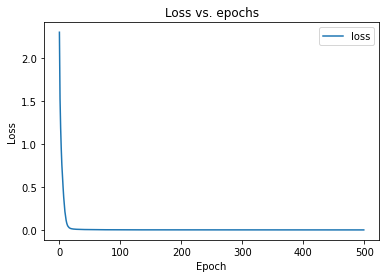

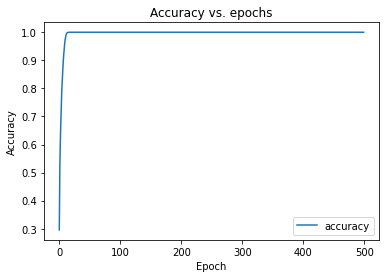

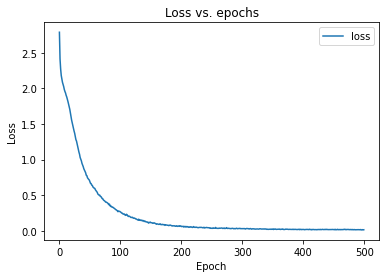

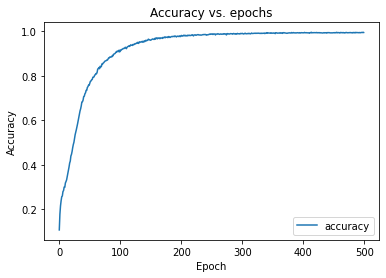

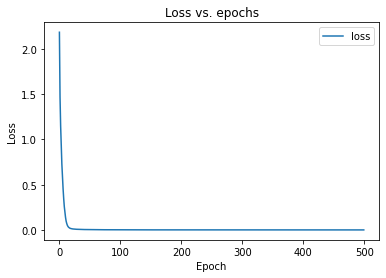

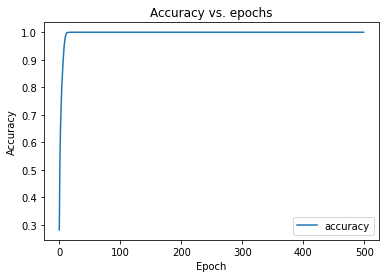

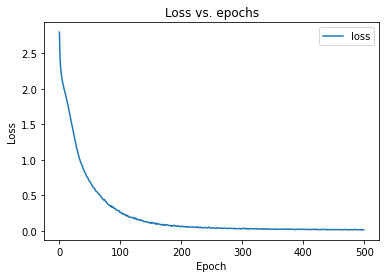

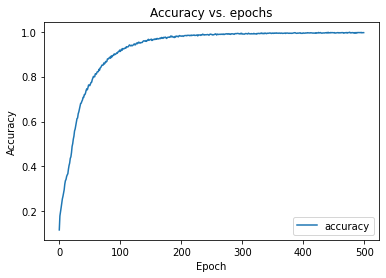

In [32]:
plot_history(history_cnn_noVal_noShuffle_noGauss)
plot_history(history_cnn_noVal_noShuffle_withGauss)
plot_history(history_cnn_noVal_withShuffle_noGauss)
plot_history(history_cnn_noVal_withShuffle_withGauss)


In [27]:
X_train_1000_f10, Y_train_1000_f10, X_test_1000_f10, Y_test_1000_f10, X_val_1000_f10, Y_val_1000_f10 = getData(is500=False,include_secondary=False,isColab=True)
X_train_1000_f10_shuffled, Y_train_1000_f10_shuffled =  coShuffled_vectors(X_train_1000_f10,Y_train_1000_f10)

In [28]:
cnnf10_noVal_noShuffle_noGauss, history_cnnf10_noVal_noShuffle_noGauss = compile_and_fit_model_basic_noVal(baseline_CNN_finalist_noGauss,
                                              "cnn_noVal_noShuffle_noGauss_20210518",
                                              X_train_1000_f10[0].shape,
                                              X_train_1000_f10,
                                              Y_train_1000_f10,
                                              save_max_epoch=True,
                                              save_final=False,
                                              patience_count=10,
                                              batch_size=2048,
                                              epochs=250,
                                              class_weight=None)

Epoch 1/200
3/3 - 5s - loss: 2.3489 - accuracy: 0.2489
INFO:tensorflow:Assets written to: cnn_noVal_noShuffle_noGauss_20210518_model_001_0.249/assets
Epoch 2/200
3/3 - 2s - loss: 1.5724 - accuracy: 0.4909
INFO:tensorflow:Assets written to: cnn_noVal_noShuffle_noGauss_20210518_model_002_0.491/assets
Epoch 3/200
3/3 - 2s - loss: 1.3207 - accuracy: 0.6064
INFO:tensorflow:Assets written to: cnn_noVal_noShuffle_noGauss_20210518_model_003_0.606/assets
Epoch 4/200
3/3 - 2s - loss: 1.0967 - accuracy: 0.6865
INFO:tensorflow:Assets written to: cnn_noVal_noShuffle_noGauss_20210518_model_004_0.687/assets
Epoch 5/200
3/3 - 2s - loss: 0.9167 - accuracy: 0.7451
INFO:tensorflow:Assets written to: cnn_noVal_noShuffle_noGauss_20210518_model_005_0.745/assets
Epoch 6/200
3/3 - 2s - loss: 0.7589 - accuracy: 0.7941
INFO:tensorflow:Assets written to: cnn_noVal_noShuffle_noGauss_20210518_model_006_0.794/assets
Epoch 7/200
3/3 - 2s - loss: 0.6171 - accuracy: 0.8398
INFO:tensorflow:Assets written to: cnn_noVal_

In [29]:
cnnf10_noVal_noShuffle_withGauss, history_cnnf10_noVal_noShuffle_withGauss = compile_and_fit_model_basic_noVal(baseline_CNN_finalist,
                                            "cnn_noVal_noShuffle_WithGauss_20210518",
                                            X_train_1000_f10[0].shape,
                                            X_train_1000_f10,
                                            Y_train_1000_f10,
                                            save_max_epoch=True,
                                            save_final=True,
                                            patience_count=2,
                                            batch_size=2048,
                                            epochs=250,
                                            class_weight=None)

Epoch 1/200
3/3 - 4s - loss: 2.8952 - accuracy: 0.1044
INFO:tensorflow:Assets written to: cnn_noVal_noShuffle_WithGauss_20210518_model_001_0.104/assets
Epoch 2/200
3/3 - 2s - loss: 2.5379 - accuracy: 0.1545
INFO:tensorflow:Assets written to: cnn_noVal_noShuffle_WithGauss_20210518_model_002_0.155/assets
Epoch 3/200
3/3 - 2s - loss: 2.4004 - accuracy: 0.1686
INFO:tensorflow:Assets written to: cnn_noVal_noShuffle_WithGauss_20210518_model_003_0.169/assets
Epoch 4/200
3/3 - 2s - loss: 2.2855 - accuracy: 0.1867
INFO:tensorflow:Assets written to: cnn_noVal_noShuffle_WithGauss_20210518_model_004_0.187/assets
Epoch 5/200
3/3 - 2s - loss: 2.2258 - accuracy: 0.2108
INFO:tensorflow:Assets written to: cnn_noVal_noShuffle_WithGauss_20210518_model_005_0.211/assets
Epoch 6/200
3/3 - 2s - loss: 2.1743 - accuracy: 0.2242
INFO:tensorflow:Assets written to: cnn_noVal_noShuffle_WithGauss_20210518_model_006_0.224/assets
Epoch 7/200
3/3 - 2s - loss: 2.1364 - accuracy: 0.2407
INFO:tensorflow:Assets written to

In [30]:

cnnf10_noVal_withShuffle_NoGauss, history_cnnf10_noVal_withShuffle_noGauss = compile_and_fit_model_basic_noVal(baseline_CNN_finalist_noGauss,
                                            "cnn_noVal_withShuffle_NoGauss_20210518",
                                            X_train_1000_f10_shuffled[0].shape,
                                            X_train_1000_f10_shuffled.numpy(),
                                            Y_train_1000_f10_shuffled.numpy(),
                                            save_max_epoch=True,
                                            save_final=True,
                                            patience_count=10,
                                            batch_size=2048,
                                            epochs=250,
                                            class_weight=None)

Epoch 1/200
3/3 - 3s - loss: 2.3753 - accuracy: 0.2498
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_001_0.250/assets
Epoch 2/200
3/3 - 2s - loss: 1.6256 - accuracy: 0.4821
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_002_0.482/assets
Epoch 3/200
3/3 - 2s - loss: 1.2850 - accuracy: 0.6187
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_003_0.619/assets
Epoch 4/200
3/3 - 2s - loss: 1.0521 - accuracy: 0.6937
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_004_0.694/assets
Epoch 5/200
3/3 - 2s - loss: 0.8621 - accuracy: 0.7537
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_005_0.754/assets
Epoch 6/200
3/3 - 2s - loss: 0.6956 - accuracy: 0.8100
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_006_0.810/assets
Epoch 7/200
3/3 - 2s - loss: 0.5594 - accuracy: 0.8564
INFO:tensorflow:Assets written to

In [31]:

cnnf10_noVal_withShuffle_withGauss, history_cnnf10_noVal_withShuffle_withGauss = compile_and_fit_model_basic_noVal(baseline_CNN_finalist,
                                            "cnn_noVal_withShuffle_NoGauss_20210518",
                                            X_train_1000_f10_shuffled[0].shape,
                                            X_train_1000_f10_shuffled.numpy(),
                                            Y_train_1000_f10_shuffled.numpy(),
                                            save_max_epoch=True,
                                            save_final=True,
                                            patience_count=10,
                                            batch_size=2048,
                                            epochs=250,
                                            class_weight=None)

Epoch 1/200
3/3 - 3s - loss: 2.8320 - accuracy: 0.1009
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_001_0.101/assets
Epoch 2/200
3/3 - 2s - loss: 2.4744 - accuracy: 0.1637
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_002_0.164/assets
Epoch 3/200
3/3 - 2s - loss: 2.3230 - accuracy: 0.1874
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_003_0.187/assets
Epoch 4/200
3/3 - 2s - loss: 2.2490 - accuracy: 0.2110
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_004_0.211/assets
Epoch 5/200
3/3 - 2s - loss: 2.1831 - accuracy: 0.2266
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_005_0.227/assets
Epoch 6/200
3/3 - 2s - loss: 2.1500 - accuracy: 0.2310
INFO:tensorflow:Assets written to: cnn_noVal_withShuffle_NoGauss_20210518_model_006_0.231/assets
Epoch 7/200
3/3 - 2s - loss: 2.1143 - accuracy: 0.2551
INFO:tensorflow:Assets written to

In [33]:
cnnf10_noVal_noShuffle_noGauss.evaluate(X_test_1000_f10,Y_test_1000_f10)
cnnf10_noVal_noShuffle_withGauss.evaluate(X_test_1000_f10,Y_test_1000_f10)
cnnf10_noVal_withShuffle_NoGauss.evaluate(X_test_1000_f10,Y_test_1000_f10)
cnnf10_noVal_withShuffle_withGauss.evaluate(X_test_1000_f10,Y_test_1000_f10)

20/20 [==============================] - 0s 6ms/step - loss: 0.3122 - accuracy: 0.9066


[0.31216517090797424, 0.9066455960273743]

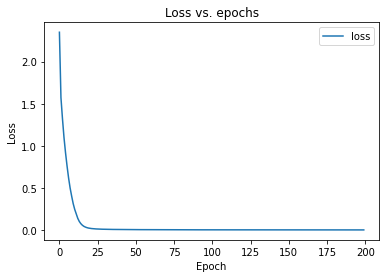

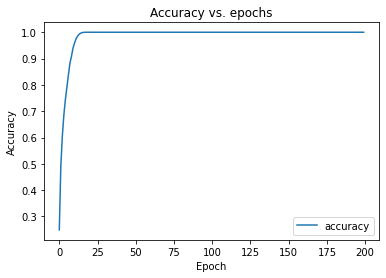

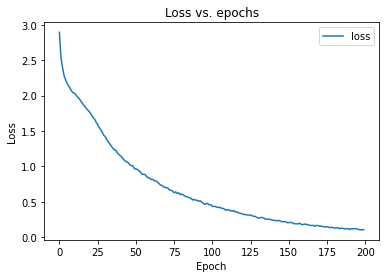

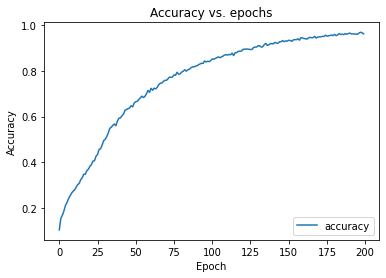

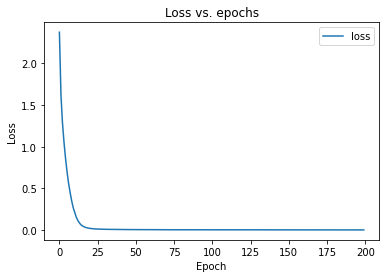

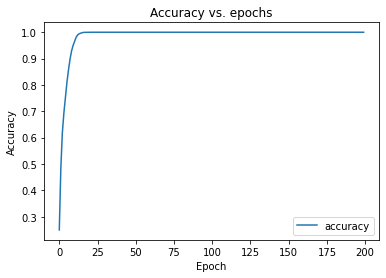

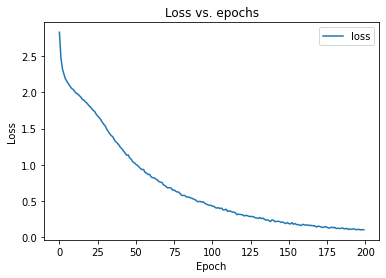

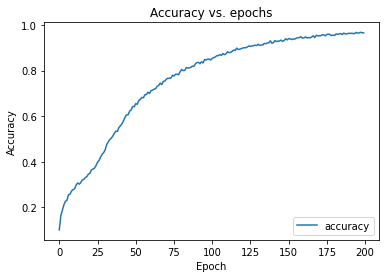

In [34]:
plot_history(history_cnnf10_noVal_noShuffle_noGauss)
plot_history(history_cnnf10_noVal_noShuffle_withGauss)
plot_history(history_cnnf10_noVal_withShuffle_noGauss)
plot_history(history_cnnf10_noVal_withShuffle_withGauss)